# Sub-Pixel Convolutional Neural Network
> In this project, we will use a convolutional neural network (CNN) model that can enhance the resolution of image using CNN from paper "Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network" [(Shi et al., 2016)](https://arxiv.org/abs/1609.05158).


# Required Packages

In [1]:
import sys, os, cv2, glob
import math, random
import skimage, PIL
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset


import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
#Access data in Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# METRICS

In [3]:
# Peak Signal to Noise Ratio (PSNR)
def psnr(target, ref):
    # Assume target is RGB/BGR image
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)
    
    diff = ref_data - target_data
    diff = diff.flatten('C')
    
    rmse = np.sqrt(np.mean(diff ** 2.))
    
    return 20 * np.log10(255. / rmse)

In [4]:
# Mean Square Error (MSE)
def mse(target, ref):
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)
    err = np.sum((target_data - ref_data) ** 2)
    
    err /= np.float(target_data.shape[0] * target_data.shape[1])
    return err

In [5]:
# Structure similarity metric
from skimage.metrics import structural_similarity as ssim

In [6]:
# Measure image quality
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel=True))
    return scores

# Efficient Sub-Pixel CNN

 Image Pre-processing

In [7]:
main_folder = '/content/drive/My Drive/MA 797 Assignments (Fall 2021)'

# Zoom in by a factor of
factor = 4 #3, 4

hr_train_names = sorted(glob.glob(main_folder+'/dataset/Train_dataset/HR/*.png', recursive=True))
lr_train_names = sorted(glob.glob(main_folder+'/dataset/Train_dataset/LR/downscale_2/*.png', recursive=True))

hr_test_names = sorted(glob.glob(main_folder+'/dataset/Test_dataset/HR/*.png', recursive=True))
lr_test_names = sorted(glob.glob(main_folder+'/dataset/Test_dataset/LR/downscale_2/*.png', recursive=True))


In [8]:
#dataset = os.path.join(main_folder, "images")
hr_test_names = os.path.join(main_folder, "/dataset/Test_dataset/HR")

test_img_paths = sorted([os.path.join(hr_test_names, fname)
        for fname in os.listdir(main_folder + hr_test_names)
        if fname.endswith(".png")])

In [9]:
h, w, c = cv2.imread(hr_train_names[0]).shape
dh, dw, dc = cv2.imread(lr_train_names[0]).shape
new_height = int(h / factor)
new_width = int(w / factor)

upscale_factor = 4 
batch_size = 8

# Ground truth - High Resolution
hr_root_dir = os.path.join(main_folder + "/dataset/Train_dataset/HR/")
hr_train_ds = image_dataset_from_directory(hr_root_dir, batch_size=batch_size,
                                           image_size=(h, w),
                                           validation_split=0.2, subset="training",
                                           seed=1337, label_mode=None)

hr_valid_ds = image_dataset_from_directory(hr_root_dir, batch_size=batch_size,
                                           image_size=(h, w),
                                           validation_split=0.2, subset="validation",
                                           seed=1337, label_mode=None)



Found 1500 files belonging to 1 classes.
Using 1200 files for training.
Found 1500 files belonging to 1 classes.
Using 300 files for validation.


In [10]:
# Decrease train dataset size
hr_train_ds = hr_train_ds.skip(80)
hr_valid_ds = hr_valid_ds.skip(int(len(hr_valid_ds)/2)) #

In [11]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image

# Scale from (0, 255) to (0, 1)
hr_train_ds = hr_train_ds.map(scaling)
hr_valid_ds = hr_valid_ds.map(scaling)

In [12]:
for batch in hr_train_ds.take(1):
    for img in batch:
      print(img.shape)
      display(array_to_img(img))

Output hidden; open in https://colab.research.google.com to view.

In [13]:
# Use TF Ops to process.
def process_input(input, input_height, input_width, upscale_factor):
    #input = cv2.resize(input, (input_width, input_height), interpolation=cv2.INTER_LINEAR)
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_height, input_width], method="bilinear")
    return y


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = hr_train_ds.map(
    lambda x: (process_input(x, new_height, new_width, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = hr_valid_ds.map(
    lambda x: (process_input(x, new_height, new_width, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

In [14]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

Output hidden; open in https://colab.research.google.com to view.

Model Setup

In [15]:
def get_model(upscale_factor=4, channels=1):
  conv_args = {"activation": "relu", "kernel_initializer": "Orthogonal", 
                 "padding": "same"}
  inputs = keras.Input(shape=(None, None, channels))
  x = layers.Conv2D(64, 5, **conv_args)(inputs)
  x = layers.Conv2D(64, 3, **conv_args)(x)
  x = layers.Conv2D(32, 3, **conv_args)(x)
  x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
  outputs = tf.nn.depth_to_space(x, upscale_factor)
  
  return keras.Model(inputs, outputs)

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import PIL



def plot_results(img, prefix, title):
  "Plot the result with zoom-in area."
  img_array = img_to_array(img)
  img_array = img_array.astype("float32") / 255.0

  # Create a new figure with a default 111 subplot.
  fig, ax = plt.subplots()
  im = ax.imshow(img_array[::-1], origin="lower")

  plt.title(title)
  # zoom-factor: 2.0, location: upper-left
  axins = zoomed_inset_axes(ax, 2, loc=2)
  axins.imshow(img_array[::-1], origin="lower")

  # Specify the limits.
  x1, x2, y1, y2 = 200, 300, 100, 200
  # Apply the x-limits.
  axins.set_xlim(x1, x2)
  # Apply the y-limits.
  axins.set_ylim(y1, y2)

  plt.yticks(visible=False)
  plt.xticks(visible=False)

  # Make the line.
  mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
  plt.savefig(str(prefix) + "-" + title + ".png")
  plt.show()


def get_lowres_image(img, upscale_factor):
  "Return low-resolution image to use as model input."
  return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC)


def upscale_image(model, img):
  "Predict the result based on input image and restore the image as RGB."
  ycbcr = img.convert("YCbCr")
  y, cb, cr = ycbcr.split()
  y = img_to_array(y)
  y = y.astype("float32") / 255.0

  input = np.expand_dims(y, axis=0)
  out = model.predict(input)

  out_img_y = out[0]
  out_img_y *= 255.0

  # Restore the image in RGB color space.
  out_img_y = out_img_y.clip(0, 255)
  out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
  out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
  out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
  out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
  out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert("RGB")

  return out_img

In [17]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(main_folder + test_img_paths[88]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 5 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [18]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, save_weights_only=True,
    monitor="loss", mode="min", save_best_only=True)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    1664      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    4624      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 1)    0         
 ambda)                                                          
                                                             

Train Model

Epoch 1/50
Mean PSNR for epoch: 19.53


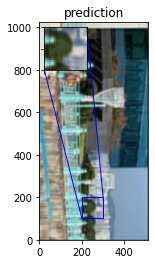

70/70 - 260s - loss: 0.0283 - val_loss: 0.0106 - 260s/epoch - 4s/step
Epoch 2/50
Mean PSNR for epoch: 20.59
70/70 - 249s - loss: 0.0090 - val_loss: 0.0082 - 249s/epoch - 4s/step
Epoch 3/50
Mean PSNR for epoch: 20.93
70/70 - 250s - loss: 0.0078 - val_loss: 0.0078 - 250s/epoch - 4s/step
Epoch 4/50
Mean PSNR for epoch: 21.25
70/70 - 249s - loss: 0.0076 - val_loss: 0.0075 - 249s/epoch - 4s/step
Epoch 5/50
Mean PSNR for epoch: 21.10
70/70 - 255s - loss: 0.0075 - val_loss: 0.0075 - 255s/epoch - 4s/step
Epoch 6/50
Mean PSNR for epoch: 20.98


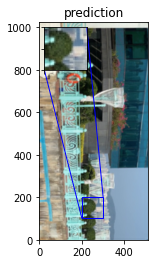

70/70 - 253s - loss: 0.0076 - val_loss: 0.0076 - 253s/epoch - 4s/step
Epoch 7/50
Mean PSNR for epoch: 20.99
70/70 - 254s - loss: 0.0074 - val_loss: 0.0074 - 254s/epoch - 4s/step
Epoch 8/50
Mean PSNR for epoch: 21.42
70/70 - 252s - loss: 0.0074 - val_loss: 0.0072 - 252s/epoch - 4s/step
Epoch 9/50
Mean PSNR for epoch: 21.63
70/70 - 251s - loss: 0.0073 - val_loss: 0.0071 - 251s/epoch - 4s/step
Epoch 10/50
Mean PSNR for epoch: 21.69
70/70 - 253s - loss: 0.0074 - val_loss: 0.0070 - 253s/epoch - 4s/step
Epoch 11/50
Mean PSNR for epoch: 21.04


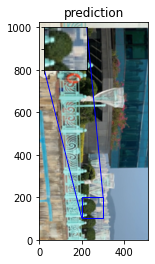

70/70 - 251s - loss: 0.0073 - val_loss: 0.0074 - 251s/epoch - 4s/step
Epoch 12/50
Mean PSNR for epoch: 21.17
70/70 - 255s - loss: 0.0073 - val_loss: 0.0074 - 255s/epoch - 4s/step
Epoch 13/50
Mean PSNR for epoch: 21.64
70/70 - 254s - loss: 0.0073 - val_loss: 0.0070 - 254s/epoch - 4s/step
Epoch 14/50
Mean PSNR for epoch: 21.55
70/70 - 256s - loss: 0.0073 - val_loss: 0.0073 - 256s/epoch - 4s/step
Epoch 15/50
Mean PSNR for epoch: 21.64
70/70 - 253s - loss: 0.0073 - val_loss: 0.0071 - 253s/epoch - 4s/step
Epoch 16/50
Mean PSNR for epoch: 20.99


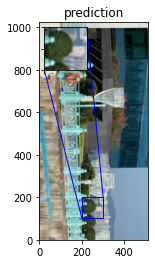

70/70 - 253s - loss: 0.0073 - val_loss: 0.0073 - 253s/epoch - 4s/step
Epoch 17/50
Mean PSNR for epoch: 21.32
70/70 - 252s - loss: 0.0072 - val_loss: 0.0073 - 252s/epoch - 4s/step
Epoch 18/50


In [ ]:
epochs = 50

model.compile(optimizer=optimizer, loss=loss_fn)
model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2)
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)


# Takes 1.5 hrs

Test Model

In [1]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0
total_test_mse = 0.0
total_test_ssim = 0.0

for index, test_img_path in enumerate(test_img_paths):
  img = load_img(main_folder + test_img_path)
  lowres_input = get_lowres_image(img, upscale_factor)
  w = lowres_input.size[0] * upscale_factor
  h = lowres_input.size[1] * upscale_factor
  highres_img = img.resize((w, h))
  prediction = upscale_image(model, lowres_input)
  lowres_img = lowres_input.resize((w, h))
  lowres_img_arr = img_to_array(lowres_img)
  highres_img_arr = img_to_array(highres_img)
  predict_img_arr = img_to_array(prediction)
  bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
  test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)
  test_mse = mse(highres_img_arr, predict_img_arr)
  test_ssim = tf.image.ssim(predict_img_arr, highres_img_arr, max_val=255)

  total_bicubic_psnr += bicubic_psnr
  total_test_psnr += test_psnr
  total_test_mse += test_mse
  total_test_ssim += test_ssim

  #print("PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr)
  #print("PSNR of predict and high resolution is %.4f" % test_psnr)
  #plot_results(lowres_img, index, "lowres")
  #plot_results(highres_img, index, "highres")
  #plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % ((total_bicubic_psnr / len(test_img_paths))))
print("Avg. PSNR of reconstructions is %.4f" % ((total_test_psnr / len(test_img_paths))))
print("Avg. MSE of reconstructions is %.4f" % ((total_test_mse/ len(test_img_paths))))
print("Avg. SSIM of reconstructions is %.4f" % ((total_test_ssim / len(test_img_paths))))

NameError: ignored

Ignore: Sample Images for Dataset

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

def plot_results(img, prefix, title):
  """Plot the result with zoom-in area."""
  img_array = img_to_array(img)
  img_array = img_array.astype("float32") / 255.0
  
  # Create a new figure with a default 111 subplot.
  fig, ax = plt.subplots()
  im = ax.imshow(img_array[::-1], origin="lower")

  plt.title(title)
  # zoom-factor: 2.0, location: upper-left
  axins = zoomed_inset_axes(ax, 2, loc=2)
  axins.imshow(img_array[::-1], origin="lower")
  
  # Specify the limits.
  x1, x2, y1, y2 = 100, 200, 50, 100  #200, 300, 100, 200
  # Apply the x-limits.
  axins.set_xlim(x1, x2)
  # Apply the y-limits.
  axins.set_ylim(y1, y2)
  
  plt.yticks(visible=False)
  plt.xticks(visible=False)
  
  # Make the line
  mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
  plt.savefig(str(prefix) + "-" + title + ".png")
  plt.show()


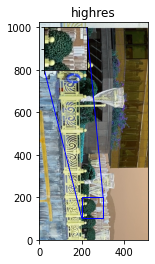

In [20]:
index = 21
highres_img = cv2.imread(main_folder + test_img_paths[88])
#highres_img = cv2.rotate(highres_img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
plot_results(highres_img, index, "highres")

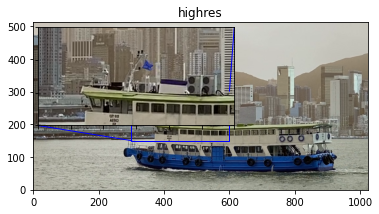

In [ ]:
index=21
highres_img = cv2.imread(main_folder + "/dataset/Train_dataset/HR/029_00049.png")
highres_img = cv2.rotate(highres_img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
plot_results(highres_img, index, "highres")

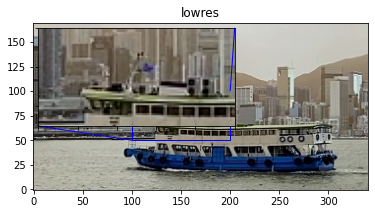

In [ ]:
index=21
lowres_img = cv2.imread(main_folder + "/dataset/Train_dataset/LR/downscale_3/029_00049.png")
lowres_img = cv2.rotate(lowres_img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
plot_results(lowres_img, index, "lowres")